In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(20)  
tf.random.set_seed(20)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[15200:53199] 
Y_train_SS = Y_train_SS[15200:53199]
Y_train_V = Y_train_V[15200:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 37789
Validation samples: 7570
Testing samples: 15140


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define MLP
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate 
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense_7 (Dense)                (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 64)           8256        ['dense_7[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 32)           2080        ['dense_8[0][0]']                
                                                                                            

Train on 37789 samples, validate on 7570 samples
Epoch 1/100
37664/37789 [============================>.] - ETA: 0s - loss: 0.0344 - dense_12_loss: 0.0275 - dense_13_loss: 0.0069 - dense_12_mse: 0.0275 - dense_13_mse: 0.0069

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.02677, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 82us/sample - loss: 0.0343 - dense_12_loss: 0.0275 - dense_13_loss: 0.0068 - dense_12_mse: 0.0275 - dense_13_mse: 0.0068 - val_loss: 0.0268 - val_dense_12_loss: 0.0200 - val_dense_13_loss: 0.0067 - val_dense_12_mse: 0.0201 - val_dense_13_mse: 0.0067
Epoch 2/100
36928/37789 [============================>.] - ETA: 0s - loss: 0.0167 - dense_12_loss: 0.0128 - dense_13_loss: 0.0040 - dense_12_mse: 0.0128 - dense_13_mse: 0.0040
Epoch 2: val_loss improved from 0.02677 to 0.02241, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 69us/sample - loss: 0.0167 - dense_12_loss: 0.0127 - dense_13_loss: 0.0040 - dense_12_mse: 0.0127 - dense_13_mse: 0.0040 - val_loss: 0.0224 - val_dense_12_loss: 0.0169 - val_dense_13_loss: 0.0055 - val_dense_12_mse: 0.0168 - val_dense_13_mse: 0.0056
Epoch 3/100
37344/37789 [============================>.] - ETA: 0s - loss: 0.0143 - dense_12_loss: 0.0106 - dense_13_loss: 0.0036 - dense_12_mse: 0.0106 - dense_13_mse: 0.0036
Epoch 3: val_loss improved from 0.02241 to 0.01976, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 71us/sample - loss: 0.0143 - dense_12_loss: 0.0106 - dense_13_loss: 0.0036 - dense_12_mse: 0.0106 - dense_13_mse: 0.0036 - val_loss: 0.0198 - val_dense_12_loss: 0.0149 - val_dense_13_loss: 0.0049 - val_dense_12_mse: 0.0149 - val_dense_13_mse: 0.0049
Epoch 4/100
37344/37789 [============================>.] - ETA: 0s - loss: 0.0110 - dense_12_loss: 0.0079 - dense_13_loss: 0.0031 - dense_12_mse: 0.0079 - dense_13_mse: 0.0031
Epoch 4: val_loss improved from 0.01976 to 0.01292, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 75us/sample - loss: 0.0110 - dense_12_loss: 0.0079 - dense_13_loss: 0.0031 - dense_12_mse: 0.0079 - dense_13_mse: 0.0031 - val_loss: 0.0129 - val_dense_12_loss: 0.0089 - val_dense_13_loss: 0.0041 - val_dense_12_mse: 0.0088 - val_dense_13_mse: 0.0041
Epoch 5/100
36864/37789 [============================>.] - ETA: 0s - loss: 0.0086 - dense_12_loss: 0.0062 - dense_13_loss: 0.0024 - dense_12_mse: 0.0062 - dense_13_mse: 0.0024
Epoch 5: val_loss improved from 0.01292 to 0.01189, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 69us/sample - loss: 0.0086 - dense_12_loss: 0.0062 - dense_13_loss: 0.0024 - dense_12_mse: 0.0062 - dense_13_mse: 0.0024 - val_loss: 0.0119 - val_dense_12_loss: 0.0083 - val_dense_13_loss: 0.0036 - val_dense_12_mse: 0.0083 - val_dense_13_mse: 0.0036
Epoch 6/100
37789/37789 [==============================] - ETA: 0s - loss: 0.0073 - dense_12_loss: 0.0052 - dense_13_loss: 0.0021 - dense_12_mse: 0.0052 - dense_13_mse: 0.0021
Epoch 6: val_loss improved from 0.01189 to 0.00949, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 69us/sample - loss: 0.0073 - dense_12_loss: 0.0052 - dense_13_loss: 0.0021 - dense_12_mse: 0.0052 - dense_13_mse: 0.0021 - val_loss: 0.0095 - val_dense_12_loss: 0.0064 - val_dense_13_loss: 0.0031 - val_dense_12_mse: 0.0064 - val_dense_13_mse: 0.0031
Epoch 7/100
37664/37789 [============================>.] - ETA: 0s - loss: 0.0062 - dense_12_loss: 0.0044 - dense_13_loss: 0.0018 - dense_12_mse: 0.0044 - dense_13_mse: 0.0018
Epoch 7: val_loss improved from 0.00949 to 0.00902, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 71us/sample - loss: 0.0062 - dense_12_loss: 0.0044 - dense_13_loss: 0.0018 - dense_12_mse: 0.0044 - dense_13_mse: 0.0018 - val_loss: 0.0090 - val_dense_12_loss: 0.0065 - val_dense_13_loss: 0.0025 - val_dense_12_mse: 0.0065 - val_dense_13_mse: 0.0025
Epoch 8/100
37408/37789 [============================>.] - ETA: 0s - loss: 0.0056 - dense_12_loss: 0.0040 - dense_13_loss: 0.0016 - dense_12_mse: 0.0040 - dense_13_mse: 0.0016
Epoch 8: val_loss improved from 0.00902 to 0.00768, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 76us/sample - loss: 0.0056 - dense_12_loss: 0.0040 - dense_13_loss: 0.0016 - dense_12_mse: 0.0040 - dense_13_mse: 0.0016 - val_loss: 0.0077 - val_dense_12_loss: 0.0057 - val_dense_13_loss: 0.0020 - val_dense_12_mse: 0.0057 - val_dense_13_mse: 0.0020
Epoch 9/100
36832/37789 [============================>.] - ETA: 0s - loss: 0.0053 - dense_12_loss: 0.0038 - dense_13_loss: 0.0015 - dense_12_mse: 0.0038 - dense_13_mse: 0.0015
Epoch 9: val_loss improved from 0.00768 to 0.00696, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 71us/sample - loss: 0.0053 - dense_12_loss: 0.0038 - dense_13_loss: 0.0015 - dense_12_mse: 0.0038 - dense_13_mse: 0.0015 - val_loss: 0.0070 - val_dense_12_loss: 0.0048 - val_dense_13_loss: 0.0022 - val_dense_12_mse: 0.0048 - val_dense_13_mse: 0.0022
Epoch 10/100
37344/37789 [============================>.] - ETA: 0s - loss: 0.0049 - dense_12_loss: 0.0035 - dense_13_loss: 0.0014 - dense_12_mse: 0.0035 - dense_13_mse: 0.0014
Epoch 10: val_loss improved from 0.00696 to 0.00627, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 71us/sample - loss: 0.0049 - dense_12_loss: 0.0035 - dense_13_loss: 0.0014 - dense_12_mse: 0.0035 - dense_13_mse: 0.0014 - val_loss: 0.0063 - val_dense_12_loss: 0.0046 - val_dense_13_loss: 0.0016 - val_dense_12_mse: 0.0046 - val_dense_13_mse: 0.0016
Epoch 11/100
37504/37789 [============================>.] - ETA: 0s - loss: 0.0046 - dense_12_loss: 0.0034 - dense_13_loss: 0.0013 - dense_12_mse: 0.0034 - dense_13_mse: 0.0013
Epoch 11: val_loss did not improve from 0.00627
37789/37789 [==============================] - 2s 46us/sample - loss: 0.0046 - dense_12_loss: 0.0034 - dense_13_loss: 0.0013 - dense_12_mse: 0.0034 - dense_13_mse: 0.0013 - val_loss: 0.0067 - val_dense_12_loss: 0.0044 - val_dense_13_loss: 0.0023 - val_dense_12_mse: 0.0044 - val_dense_13_mse: 0.0023
Epoch 12/100
37664/37789 [============================>.] - ETA: 0s - loss: 0.0046 - dense_12_loss: 0.0034 - dense_13_loss: 0.0013 - dense_12_mse: 0.0034 - dense_13_mse: 0.001

37789/37789 [==============================] - 3s 72us/sample - loss: 0.0043 - dense_12_loss: 0.0031 - dense_13_loss: 0.0012 - dense_12_mse: 0.0031 - dense_13_mse: 0.0012 - val_loss: 0.0062 - val_dense_12_loss: 0.0048 - val_dense_13_loss: 0.0014 - val_dense_12_mse: 0.0048 - val_dense_13_mse: 0.0014
Epoch 14/100
37152/37789 [============================>.] - ETA: 0s - loss: 0.0043 - dense_12_loss: 0.0031 - dense_13_loss: 0.0011 - dense_12_mse: 0.0031 - dense_13_mse: 0.0011
Epoch 14: val_loss did not improve from 0.00623
37789/37789 [==============================] - 2s 47us/sample - loss: 0.0043 - dense_12_loss: 0.0031 - dense_13_loss: 0.0011 - dense_12_mse: 0.0031 - dense_13_mse: 0.0011 - val_loss: 0.0073 - val_dense_12_loss: 0.0050 - val_dense_13_loss: 0.0023 - val_dense_12_mse: 0.0050 - val_dense_13_mse: 0.0023
Epoch 15/100
37600/37789 [============================>.] - ETA: 0s - loss: 0.0041 - dense_12_loss: 0.0030 - dense_13_loss: 0.0011 - dense_12_mse: 0.0030 - dense_13_mse: 0.001

37789/37789 [==============================] - 3s 69us/sample - loss: 0.0041 - dense_12_loss: 0.0030 - dense_13_loss: 0.0011 - dense_12_mse: 0.0030 - dense_13_mse: 0.0011 - val_loss: 0.0059 - val_dense_12_loss: 0.0048 - val_dense_13_loss: 0.0011 - val_dense_12_mse: 0.0048 - val_dense_13_mse: 0.0011
Epoch 16/100
37408/37789 [============================>.] - ETA: 0s - loss: 0.0041 - dense_12_loss: 0.0030 - dense_13_loss: 0.0011 - dense_12_mse: 0.0030 - dense_13_mse: 0.0011
Epoch 16: val_loss did not improve from 0.00592
37789/37789 [==============================] - 2s 46us/sample - loss: 0.0041 - dense_12_loss: 0.0030 - dense_13_loss: 0.0010 - dense_12_mse: 0.0030 - dense_13_mse: 0.0010 - val_loss: 0.0066 - val_dense_12_loss: 0.0054 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0054 - val_dense_13_mse: 0.0012
Epoch 17/100
36704/37789 [============================>.] - ETA: 0s - loss: 0.0039 - dense_12_loss: 0.0029 - dense_13_loss: 0.0010 - dense_12_mse: 0.0029 - dense_13_mse: 0.001

37789/37789 [==============================] - 3s 76us/sample - loss: 0.0038 - dense_12_loss: 0.0028 - dense_13_loss: 9.7290e-04 - dense_12_mse: 0.0028 - dense_13_mse: 9.7290e-04 - val_loss: 0.0049 - val_dense_12_loss: 0.0037 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0037 - val_dense_13_mse: 0.0012
Epoch 19/100
36864/37789 [============================>.] - ETA: 0s - loss: 0.0036 - dense_12_loss: 0.0027 - dense_13_loss: 9.2615e-04 - dense_12_mse: 0.0027 - dense_13_mse: 9.2615e-04
Epoch 19: val_loss improved from 0.00491 to 0.00462, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 70us/sample - loss: 0.0036 - dense_12_loss: 0.0027 - dense_13_loss: 9.2664e-04 - dense_12_mse: 0.0027 - dense_13_mse: 9.2670e-04 - val_loss: 0.0046 - val_dense_12_loss: 0.0037 - val_dense_13_loss: 9.1757e-04 - val_dense_12_mse: 0.0037 - val_dense_13_mse: 9.1905e-04
Epoch 20/100
36864/37789 [============================>.] - ETA: 0s - loss: 0.0037 - dense_12_loss: 0.0027 - dense_13_loss: 9.3950e-04 - dense_12_mse: 0.0027 - dense_13_mse: 9.3950e-04
Epoch 20: val_loss did not improve from 0.00462
37789/37789 [==============================] - 2s 45us/sample - loss: 0.0037 - dense_12_loss: 0.0027 - dense_13_loss: 9.3905e-04 - dense_12_mse: 0.0027 - dense_13_mse: 9.3911e-04 - val_loss: 0.0062 - val_dense_12_loss: 0.0050 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0050 - val_dense_13_mse: 0.0012
Epoch 21/100
36768/37789 [============================>.] - ETA: 0s - loss: 0.0037 - dense_12_loss: 0.0027 - dense_13_loss: 9.5969e-04 - dense_

37789/37789 [==============================] - 3s 72us/sample - loss: 0.0031 - dense_12_loss: 0.0023 - dense_13_loss: 7.9919e-04 - dense_12_mse: 0.0023 - dense_13_mse: 7.9905e-04 - val_loss: 0.0046 - val_dense_12_loss: 0.0033 - val_dense_13_loss: 0.0013 - val_dense_12_mse: 0.0033 - val_dense_13_mse: 0.0013
Epoch 29/100
37408/37789 [============================>.] - ETA: 0s - loss: 0.0031 - dense_12_loss: 0.0023 - dense_13_loss: 8.1918e-04 - dense_12_mse: 0.0023 - dense_13_mse: 8.1918e-04
Epoch 29: val_loss did not improve from 0.00460
37789/37789 [==============================] - 2s 46us/sample - loss: 0.0031 - dense_12_loss: 0.0023 - dense_13_loss: 8.2115e-04 - dense_12_mse: 0.0023 - dense_13_mse: 8.2121e-04 - val_loss: 0.0048 - val_dense_12_loss: 0.0036 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0036 - val_dense_13_mse: 0.0012
Epoch 30/100
37376/37789 [============================>.] - ETA: 0s - loss: 0.0030 - dense_12_loss: 0.0023 - dense_13_loss: 7.5192e-04 - dense_12_mse: 

37789/37789 [==============================] - 3s 71us/sample - loss: 0.0028 - dense_12_loss: 0.0021 - dense_13_loss: 7.0478e-04 - dense_12_mse: 0.0021 - dense_13_mse: 7.0483e-04 - val_loss: 0.0041 - val_dense_12_loss: 0.0032 - val_dense_13_loss: 8.4218e-04 - val_dense_12_mse: 0.0032 - val_dense_13_mse: 8.4370e-04
Epoch 34/100
36704/37789 [============================>.] - ETA: 0s - loss: 0.0027 - dense_12_loss: 0.0020 - dense_13_loss: 6.9184e-04 - dense_12_mse: 0.0020 - dense_13_mse: 6.9184e-04
Epoch 34: val_loss improved from 0.00406 to 0.00378, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


37789/37789 [==============================] - 3s 76us/sample - loss: 0.0027 - dense_12_loss: 0.0020 - dense_13_loss: 6.8190e-04 - dense_12_mse: 0.0020 - dense_13_mse: 6.8190e-04 - val_loss: 0.0038 - val_dense_12_loss: 0.0028 - val_dense_13_loss: 9.4507e-04 - val_dense_12_mse: 0.0028 - val_dense_13_mse: 9.4680e-04
Epoch 35/100
37184/37789 [============================>.] - ETA: 0s - loss: 0.0028 - dense_12_loss: 0.0021 - dense_13_loss: 7.0142e-04 - dense_12_mse: 0.0021 - dense_13_mse: 7.0142e-04
Epoch 35: val_loss did not improve from 0.00378
37789/37789 [==============================] - 2s 48us/sample - loss: 0.0028 - dense_12_loss: 0.0021 - dense_13_loss: 7.1235e-04 - dense_12_mse: 0.0021 - dense_13_mse: 7.1235e-04 - val_loss: 0.0072 - val_dense_12_loss: 0.0055 - val_dense_13_loss: 0.0017 - val_dense_12_mse: 0.0055 - val_dense_13_mse: 0.0017
Epoch 36/100
37504/37789 [============================>.] - ETA: 0s - loss: 0.0027 - dense_12_loss: 0.0021 - dense_13_loss: 6.6321e-04 - dense_

37789/37789 [==============================] - 3s 79us/sample - loss: 0.0024 - dense_12_loss: 0.0018 - dense_13_loss: 6.1337e-04 - dense_12_mse: 0.0018 - dense_13_mse: 6.1337e-04 - val_loss: 0.0035 - val_dense_12_loss: 0.0027 - val_dense_13_loss: 8.1455e-04 - val_dense_12_mse: 0.0027 - val_dense_13_mse: 8.1033e-04
Epoch 43/100
37789/37789 [==============================] - ETA: 0s - loss: 0.0024 - dense_12_loss: 0.0018 - dense_13_loss: 5.9458e-04 - dense_12_mse: 0.0018 - dense_13_mse: 5.9459e-04
Epoch 43: val_loss did not improve from 0.00353
37789/37789 [==============================] - 2s 46us/sample - loss: 0.0024 - dense_12_loss: 0.0018 - dense_13_loss: 5.9458e-04 - dense_12_mse: 0.0018 - dense_13_mse: 5.9459e-04 - val_loss: 0.0043 - val_dense_12_loss: 0.0031 - val_dense_13_loss: 0.0012 - val_dense_12_mse: 0.0031 - val_dense_13_mse: 0.0012
Epoch 44/100
37472/37789 [============================>.] - ETA: 0s - loss: 0.0023 - dense_12_loss: 0.0017 - dense_13_loss: 5.8437e-04 - dense_

37789/37789 [==============================] - 3s 71us/sample - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 5.7344e-04 - dense_12_mse: 0.0016 - dense_13_mse: 5.7347e-04 - val_loss: 0.0035 - val_dense_12_loss: 0.0026 - val_dense_13_loss: 9.0618e-04 - val_dense_12_mse: 0.0026 - val_dense_13_mse: 9.0722e-04
Epoch 52/100
37376/37789 [============================>.] - ETA: 0s - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 5.7989e-04 - dense_12_mse: 0.0016 - dense_13_mse: 5.7989e-04
Epoch 52: val_loss did not improve from 0.00351
37789/37789 [==============================] - 2s 48us/sample - loss: 0.0022 - dense_12_loss: 0.0016 - dense_13_loss: 5.7563e-04 - dense_12_mse: 0.0016 - dense_13_mse: 5.7567e-04 - val_loss: 0.0042 - val_dense_12_loss: 0.0034 - val_dense_13_loss: 7.8882e-04 - val_dense_12_mse: 0.0034 - val_dense_13_mse: 7.9002e-04
Epoch 53/100
37440/37789 [============================>.] - ETA: 0s - loss: 0.0020 - dense_12_loss: 0.0015 - dense_13_loss: 5.2243e-04 

37789/37789 [==============================] - 3s 71us/sample - loss: 0.0020 - dense_12_loss: 0.0015 - dense_13_loss: 5.2140e-04 - dense_12_mse: 0.0015 - dense_13_mse: 5.2143e-04 - val_loss: 0.0034 - val_dense_12_loss: 0.0028 - val_dense_13_loss: 5.5736e-04 - val_dense_12_mse: 0.0028 - val_dense_13_mse: 5.5831e-04
Epoch 64/100
37280/37789 [============================>.] - ETA: 0s - loss: 0.0020 - dense_12_loss: 0.0014 - dense_13_loss: 5.3652e-04 - dense_12_mse: 0.0014 - dense_13_mse: 5.3652e-04
Epoch 64: val_loss did not improve from 0.00338
37789/37789 [==============================] - 2s 46us/sample - loss: 0.0020 - dense_12_loss: 0.0014 - dense_13_loss: 5.3555e-04 - dense_12_mse: 0.0014 - dense_13_mse: 5.3559e-04 - val_loss: 0.0037 - val_dense_12_loss: 0.0030 - val_dense_13_loss: 7.3624e-04 - val_dense_12_mse: 0.0030 - val_dense_13_mse: 7.3416e-04
Epoch 65/100
37789/37789 [==============================] - ETA: 0s - loss: 0.0020 - dense_12_loss: 0.0014 - dense_13_loss: 5.2853e-04 

37789/37789 [==============================] - 3s 78us/sample - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 5.0659e-04 - dense_12_mse: 0.0014 - dense_13_mse: 5.0658e-04 - val_loss: 0.0033 - val_dense_12_loss: 0.0025 - val_dense_13_loss: 7.8267e-04 - val_dense_12_mse: 0.0025 - val_dense_13_mse: 7.8403e-04
Epoch 68/100
36864/37789 [============================>.] - ETA: 0s - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 4.9657e-04 - dense_12_mse: 0.0014 - dense_13_mse: 4.9657e-04
Epoch 68: val_loss did not improve from 0.00333
37789/37789 [==============================] - 2s 48us/sample - loss: 0.0019 - dense_12_loss: 0.0014 - dense_13_loss: 4.9377e-04 - dense_12_mse: 0.0014 - dense_13_mse: 4.9380e-04 - val_loss: 0.0047 - val_dense_12_loss: 0.0041 - val_dense_13_loss: 6.4541e-04 - val_dense_12_mse: 0.0041 - val_dense_13_mse: 6.4541e-04
Epoch 69/100
37568/37789 [============================>.] - ETA: 0s - loss: 0.0018 - dense_12_loss: 0.0013 - dense_13_loss: 4.6586e-04 

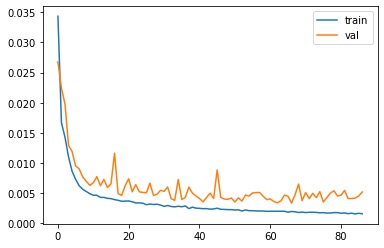

---Training time: 177.12044859 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto') 
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.95126, Train (V) - 0.83529
R2 scores: Validation (SS) - 0.90918, Validation (V) - 0.71010
R2 scores: Testing (SS) - 0.76424, Testing (V) - 0.57757
RMSE scores: Train (SS) - 0.03625, Train (V) - 0.02472
RMSE scores: Validation (SS) - 0.05985, Validation (V) - 0.04005
RMSE scores: Testing (SS) - 0.10452, Testing (V) - 0.05544


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

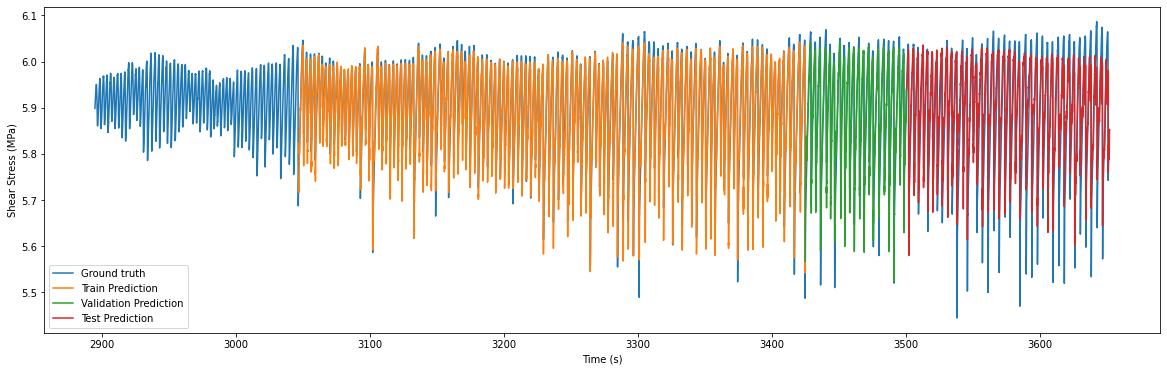

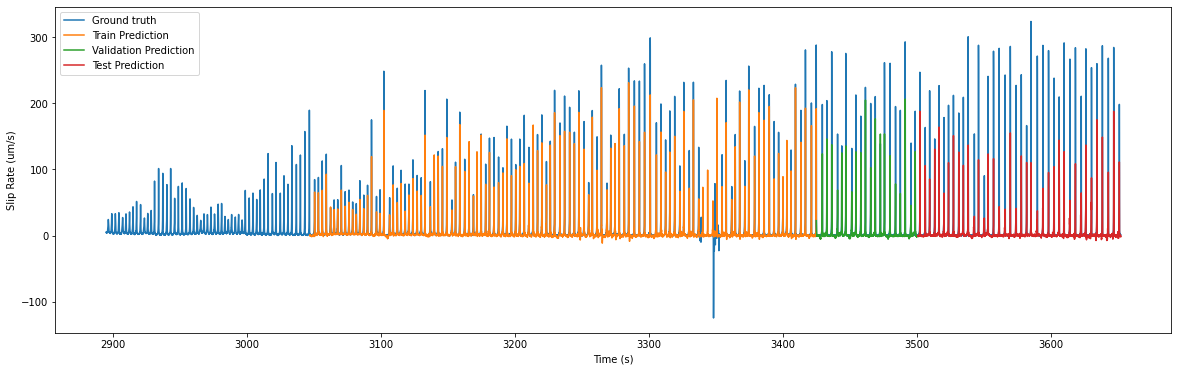

In [ ]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[15200:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

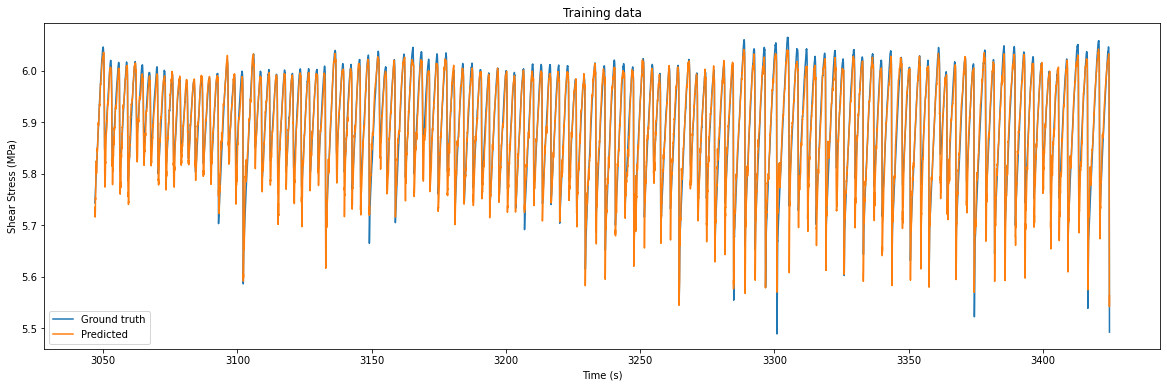

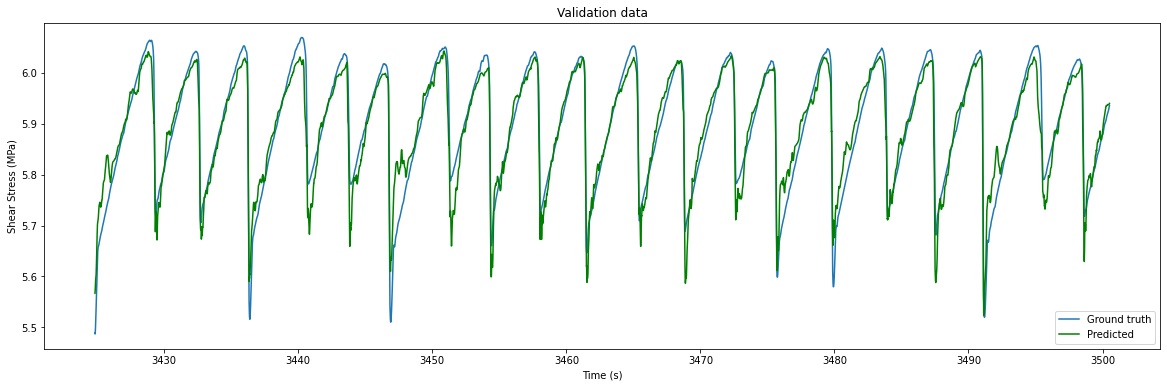

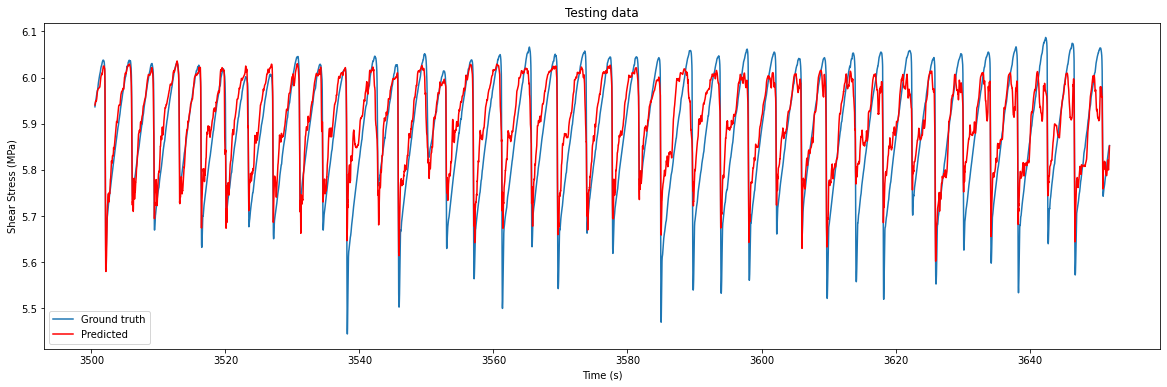

In [ ]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

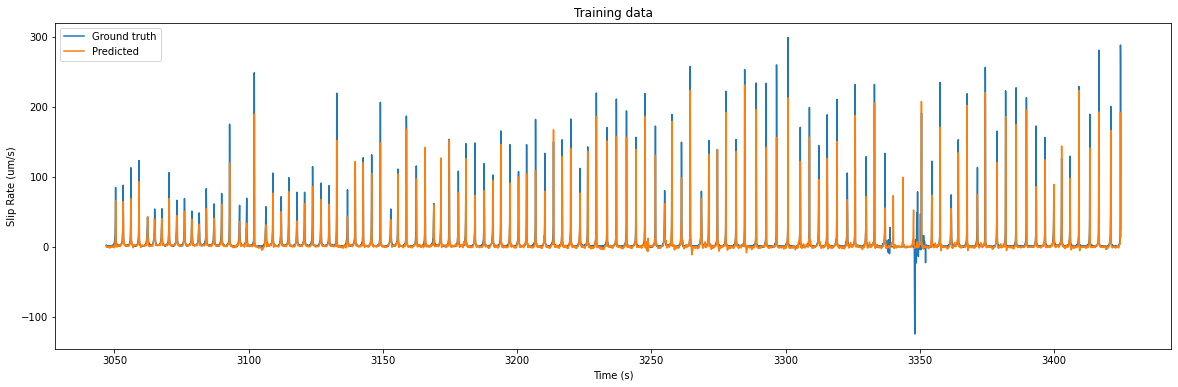

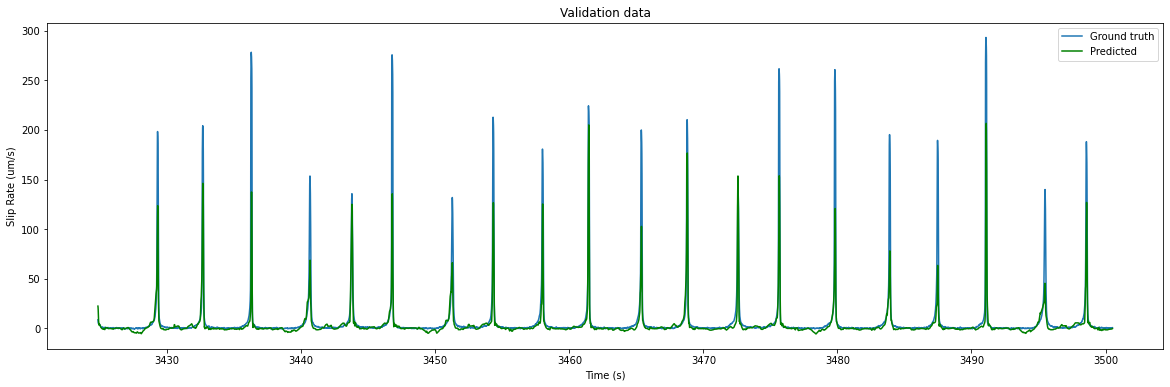

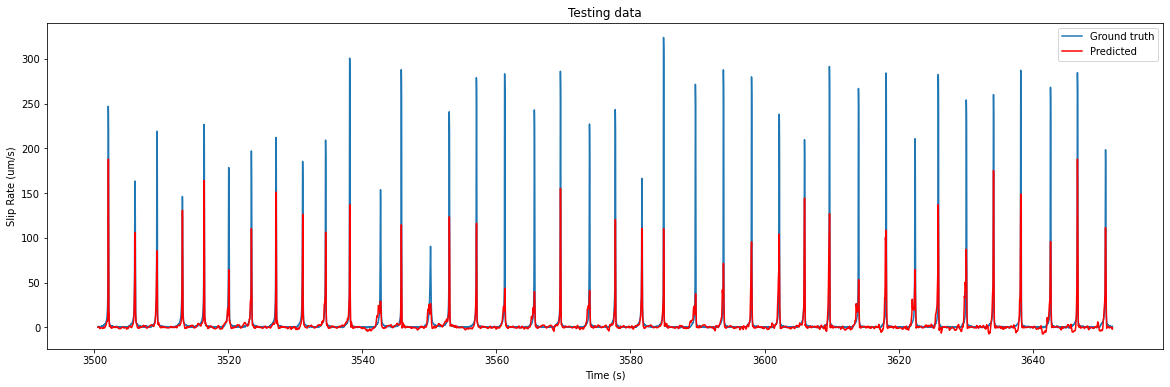

In [ ]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')